# Image Filtering

The main objectives of this module are:

* Implement point filtering with look-up tables.
* Implement region filtering with kernel convolution, morphological operations and edge detection.
* Understand spatial frequency information with the Fourier transform.

## 1. Look-up tables

Look-up tables are a very useful tool to perform simple pixel-level filtering of an image.

Numpy arrays indexing ([see reference here](http://docs.scipy.org/doc/numpy/user/basics.indexing.html)) is a very powerful tool, but can be a bit counter-intuitive at first. We will use it to quickly create and use look-up tables to transform an image.

Look at the short example below. 

We construct an image with 4 possible values for each pixel (-> $I(x,y) \in \{0,1,2,3\}$). We then build the following LUT:

|Input value|Output value|
|--|--|
|0|2|
|1|3|
|2|1|
|3|0|

And we apply it on the image.

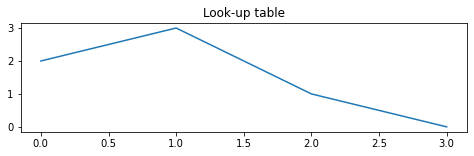

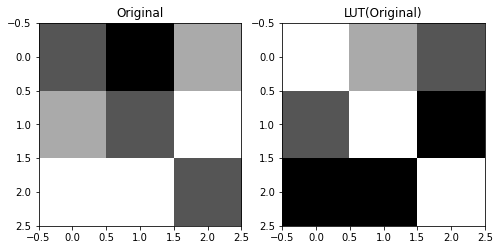

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

# Let's create a 3x3 "image" with 4 possible pixel values (in [0,3])
im = np.array([[1,0,2],[2,1,3],[3,3,1]])

# look-up table is a vector of size 4 mapping the new value for the pixels of m
lut = np.array([2,3,1,0]) # maps 0 -> 2, 1 -> 3, 2 -> 1, 3 -> 0

plt.figure(figsize=(8,2))
plt.plot(lut)
plt.title('Look-up table')
plt.show()

# we can use numpy vector indexing to apply the look-up table:
new_im = lut[im] # This will create a new array with the same size as m

plt.figure(figsize=(8,4))
plt.subplot(1,2,1) #supblot is useful to display images side-by-side
plt.imshow(im, cmap=cm.gray)
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(new_im, cmap=cm.gray)
plt.title('LUT(Original)')
plt.show()

**Starting from this example, create the following LUTs** and apply them to the "walking.jpg" image:
1. For inverting an image (so that $0 \rightarrow 255$, $255 \rightarrow 0$)
1. To keep only graylevel such that $g \ge t$, setting all other values to 0.
1. To reduce the number of gray levels from 256 to 8 (so that $255 \rightarrow 7$, $0 \rightarrow 0$).
1. To "stretch" the histogram so that, given a **minimum value** $T_{min}$ and a **maximum value** $T_{max}$, we have :
    * If $I(x,y) < T_{min}$, the new value is set to 0
    * If $I(x,y) > T_{max}$, the new value is set to 255
    * Values between $T_{min}$ and $T_{max}$ are stretched to cover the entire histogram.
1. to perform an **equalization** of the cameraman image (so that the histogram becomes "as flat as possible")

(799, 640) uint8


<Figure size 432x288 with 0 Axes>

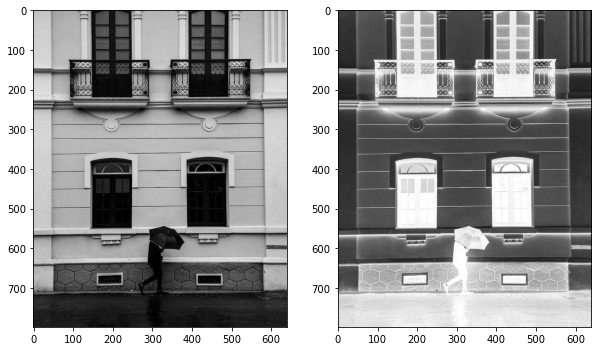

<Figure size 432x288 with 0 Axes>

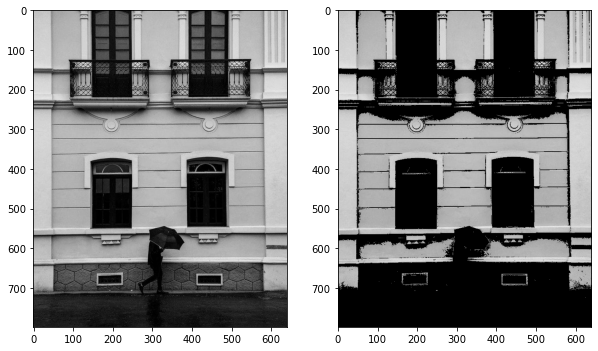

<Figure size 432x288 with 0 Axes>

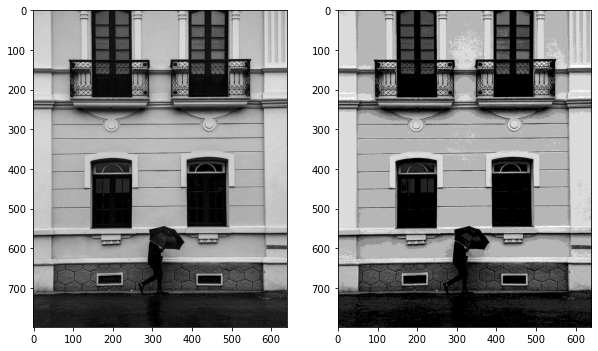

<Figure size 432x288 with 0 Axes>

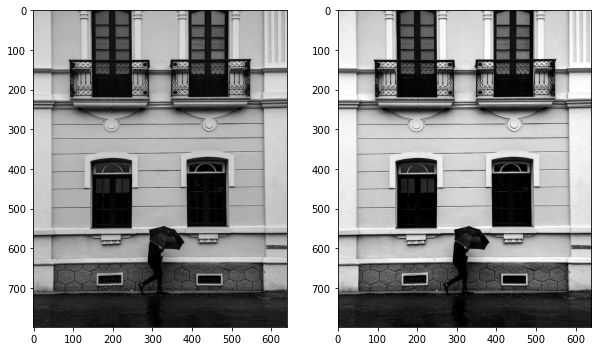

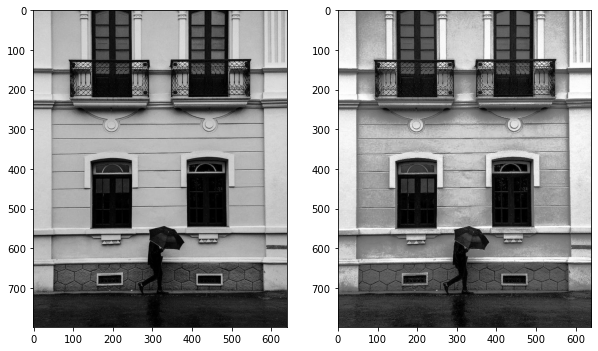

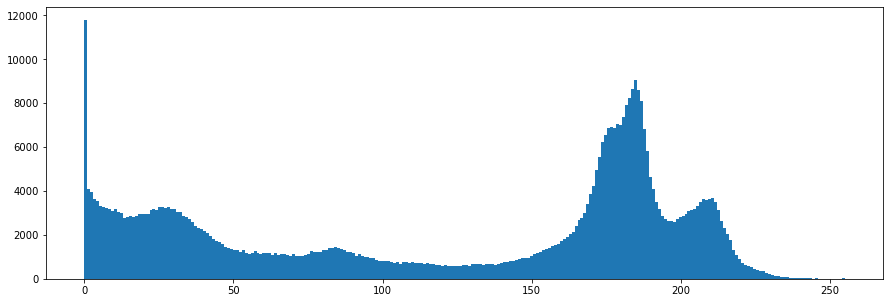

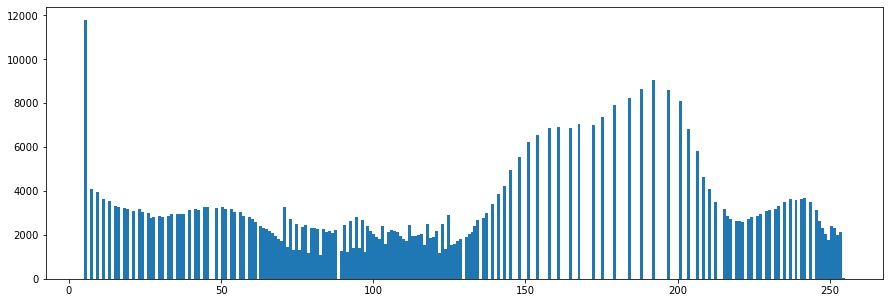

In [2]:
from skimage.io import imread,imshow,imsave

im = imread('walking.jpg')
print(im.shape, im.dtype)

## -- Your code here -- ##

#ex1
lut1 = np.arange(255,-1,-1)
im_inv = lut1[im]
plt.gray()
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(im_inv)
plt.show()

#ex2
t = 160
lut2 = np.zeros(256, dtype=int)
for i in range(t):
    lut2[i] = 0
for j in range(t, 256):
    lut2[j] = j
im_t = lut2[im]
plt.gray()
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(im_t)
plt.show()

#ex3
lut3 = np.zeros(256, dtype=int)
i = 0
while i < 8:
    for j in range(i*32, (i+1)*32):
        lut3[j] = i
    i += 1
im_low = lut3[im]
plt.gray()
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(im_low)
plt.show()

#ex4
t_min = 5
t_max = 220
lut4 = np.arange(256)
for i in range(256):
    if i < t_min:
        lut4[i] = 0
    elif i > t_max:
        lut4[i] = 255
    else:
        lut4[i] = (255/(t_max-t_min)) * (lut4[i]-t_min)
im_stretch = lut4[im]
plt.gray()
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(im_stretch)
plt.show()

#ex5
hist, _ = np.histogram(im, bins=np.arange(257), density=True)
c_hist = np.zeros((256,))
for i in range(256):
    c_hist[i] = hist[:i+1].sum()
lut5 = (255*c_hist).astype('int')
im_eq = lut5[im]
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(im_eq)
plt.show()

plt.figure(figsize=(15,5))
plt.hist(im.flatten(), bins=256)
plt.figure(figsize=(15,5))
plt.hist(im_eq.flatten(), bins=256)
plt.show()

**Need more help? You can check the following videos:**

* [Look-Up Tables](https://www.youtube.com/watch?v=PHiiKoSsVac&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=13)
* [Auto-levels](https://www.youtube.com/watch?v=DLN4jfBJakQ&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=14)
* [Equalization](https://www.youtube.com/watch?v=C44WuMUudik&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=15)

## 2. Kernel convolution

Kernal convolution allows us to filter an image based on the values of a neighborhood.

Write a program that applies a 3x3 kernel convolution on an image. Use it on the "walking" image to perform a mean filter.

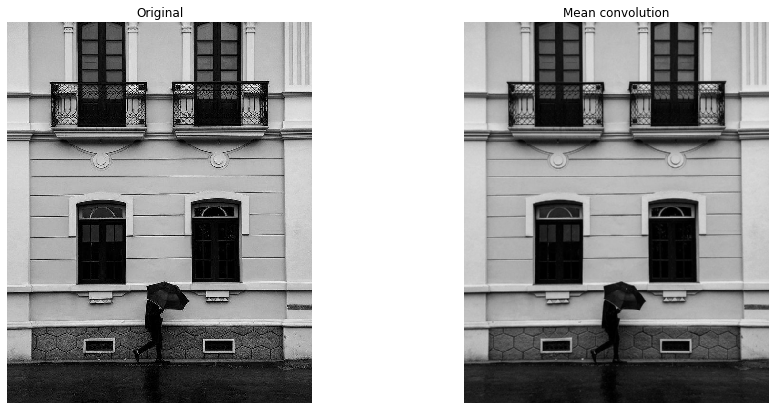

In [3]:
def convolve(im,k):
    # do the zero-padding (note : this code will only work for 3x3 kernels!)
    im2 = np.zeros((im.shape[0]+2, im.shape[1]+2))
    im2[1:-1, 1:-1] = im
    
    im_out = np.zeros(im.shape)
    
    # convolution using the "naive" approach
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            im_out[i,j] = (im2[i:i+3,j:j+3]*k).sum() # Multiplying two np arrays of the same size = element-wise multiplication
    
    return im_out

im = imread('walking.jpg')

## -- Your code here -- ##
mean_k = np.ones((3,3))/9.
im_mean = convolve(im,mean_k)

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=255, interpolation='none')
plt.title('Original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(im_mean, cmap=plt.cm.gray, vmin=0, vmax=255, interpolation='none')
plt.title('Mean convolution')
plt.axis('off')
plt.show()

Using the [median filter](https://scikit-image.org/docs/stable/api/skimage.filters.rank.html#skimage.filters.rank.median) and the [mean filter](https://scikit-image.org/docs/dev/api/skimage.filters.rank.html#skimage.filters.rank.mean) from scikit-image, compare the behaviour of the two filters with neighborhood of increasing sizes on the "noisy" astronaut image:

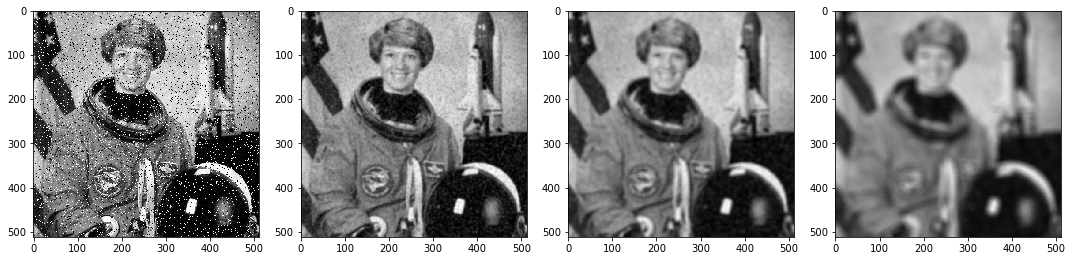

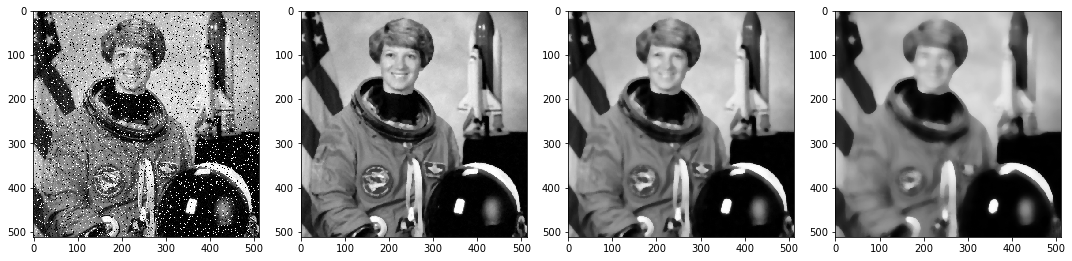

In [4]:
from skimage.filters.rank import mean, median
from skimage.morphology import disk

im = imread('astronaut_noisy.jpg')
## -- Your code here -- ##
plt.figure(figsize=(15,5))
plt.subplot(1,4,1)
imshow(im)
plt.subplot(1,4,2)
imshow(mean(im,disk(3)))
plt.subplot(1,4,3)
imshow(mean(im,disk(5)))
plt.subplot(1,4,4)
imshow(mean(im,disk(10)))
plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,4,1)
imshow(im)
plt.subplot(1,4,2)
imshow(median(im,disk(3)))
plt.subplot(1,4,3)
imshow(median(im,disk(5)))
plt.subplot(1,4,4)
imshow(median(im,disk(10)))
plt.show()

**Need more help? You can check the following videos:**

* [Kernel convolution](https://www.youtube.com/watch?v=FaTvGWPnLng&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=16)
* [Mean and Median filters](https://www.youtube.com/watch?v=GLTuF3lwDLs&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=17)

## 3. 2D Fourier transform

The 2D Fourier transform allows us to get a representation of the spatial frequencies present in an image. A very powerful way of filtering images is to modify those frequencies directly by modifying the "Fourier image", and to use the inverse transform to get the pixel values of the filtered image.

Let's illustrate that with a fake example. We start with a completely random signal and compute the Fourier transform. Note that the Fourier image is complex, so we use its amplitude. As the range of amplitudes is so high that we don't see much in the resulting image, we display the log of the amplitude.

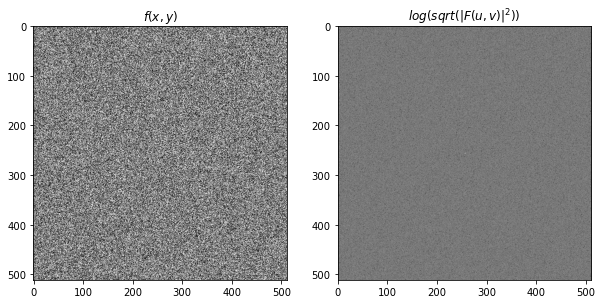

In [5]:
from numpy.fft import fft2,ifft2,fftshift,ifftshift
# fft2 -> Fourier transform
# ifft2 -> Inverse transform
# fftshift & ifftshift -> reorganize the "Fourier image" to make it more easily interpretable.

def fourier(im):
    return fftshift(fft2(im))

def ifourier(f):
    return ifft2(ifftshift(f)).real

im = np.random.random((512,512))
f = fftshift(fft2(im))
amplitude = np.sqrt(np.real(f)**2+np.imag(f)**2)

plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.imshow(im,cmap = plt.cm.gray)
plt.title('$f(x,y)$')
plt.subplot(1,2,2)
plt.imshow(np.log(amplitude))# show log so as to see more than just the global maximum
plt.title('$log(sqrt(|F(u,v)|^2))$')
plt.show()

We could now, for instance, decide to add an horizontal frequency by creating peaks in the Fourier image on the horizontal axis. The further away from the center we put the peaks, the higher the frequency.

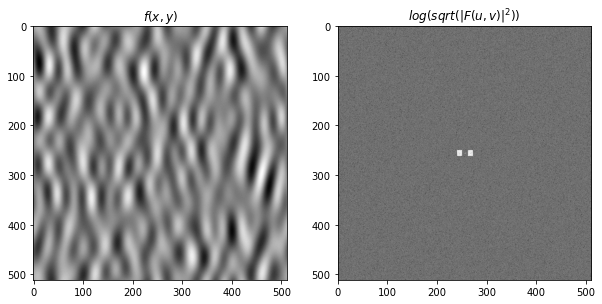

In [6]:
f2 = f.copy()
f2[250:262,262:272] *= 1000
f2[250:262,240:250] *= 1000
amplitude = np.sqrt(np.real(f2)**2+np.imag(f2)**2)
im2 = ifft2(ifftshift(f2)).real

plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.imshow(im2,cmap = plt.cm.gray)
plt.title('$f(x,y)$')
plt.subplot(1,2,2)
plt.imshow(np.log(amplitude))# show log so as to see more than just the global maximum
plt.title('$log(sqrt(|F(u,v)|^2))$')
plt.show()

Now we could also decide to mask the central region, which would remove the peaks that we just created and put all those values at zero. The image will once again look random:

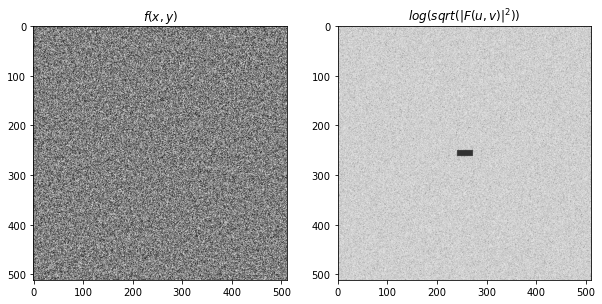

In [7]:
f3 = f2.copy()
f3[250:262,240:272] = 0
amplitude = np.sqrt(np.real(f3)**2+np.imag(f3)**2)
im3 = ifft2(ifftshift(f3)).real

plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.imshow(im3,cmap = plt.cm.gray)
plt.title('$f(x,y)$')
plt.subplot(1,2,2)
plt.imshow(np.log(amplitude, where=amplitude>0))
plt.title('$log(sqrt(|F(u,v)|^2))$')
plt.show()

Starting from those examples and the code below:

1. Use the Fourier transform to reduce the [dithering](https://en.wikipedia.org/wiki/Dither) of the *moire.png* image by building a low-pass filter.
1. Build a high-pass filter using Fourier transform and apply the filter to the "walking" image.

<ipython-input-8-1ce64ccf93e7>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im = imread('moire1.png').astype(np.float)


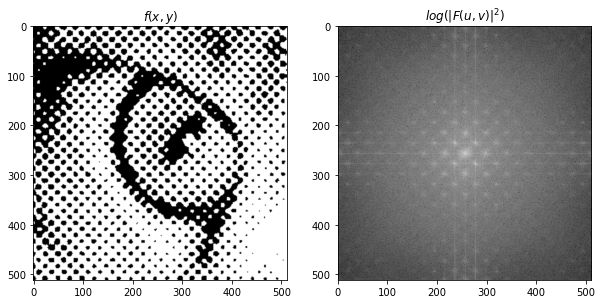

In [8]:
im = imread('moire1.png').astype(np.float)
f = fftshift(fft2(im)) # shift Fourier image so that the center corresponds to low frequencies

amplitude = np.sqrt(np.real(f)**2+np.imag(f)**2)

plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.imshow(im,cmap = plt.cm.gray)
plt.title('$f(x,y)$')
plt.subplot(1,2,2)
plt.imshow(np.log(amplitude))# show log so as to see more than just the global maximum
plt.title('$log(|F(u,v)|^2)$')
plt.show()

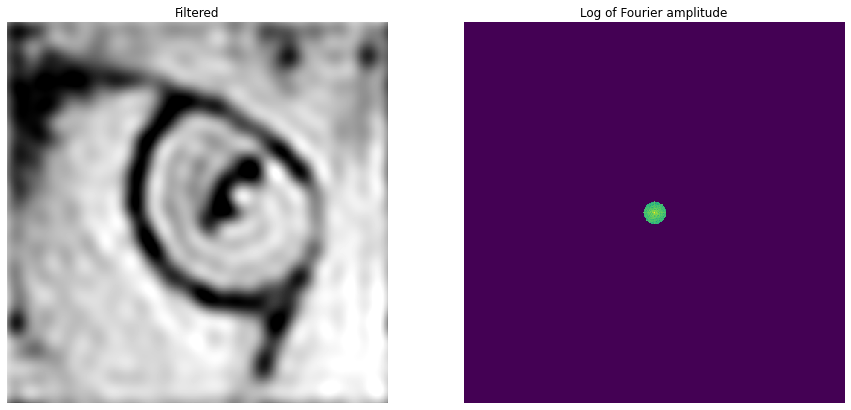

In [9]:
## -- Your code here -- ##
# Quick function to create a disk shaped mask to apply to our Fourier image
def get_disk_mask(r, imshape):
    a, b = imshape[0]//2, imshape[1]//2
    
    y,x = np.ogrid[-a:imshape[0]-a, -b:imshape[1]-b]
    mask = x*x + y*y <= r*r
    return mask
# Only keep the low frequencies
mask = get_disk_mask(15,f.shape)
f2 = f*mask

im_moire2 = ifourier(f2)

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.imshow(im_moire2, cmap=plt.cm.gray, vmin=0, vmax=255, interpolation='none')
plt.title('Filtered')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(np.log(np.abs(f2), where=np.abs(f2)>0), interpolation='none', cmap='viridis')
plt.title('Log of Fourier amplitude')
plt.axis('off')
plt.show()

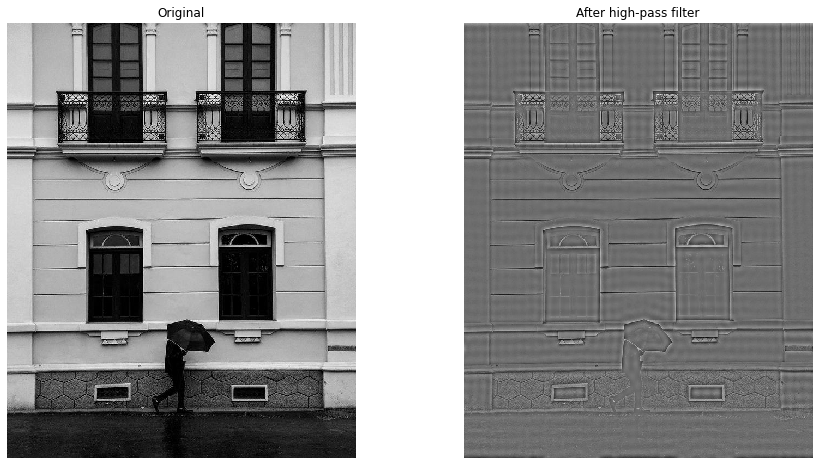

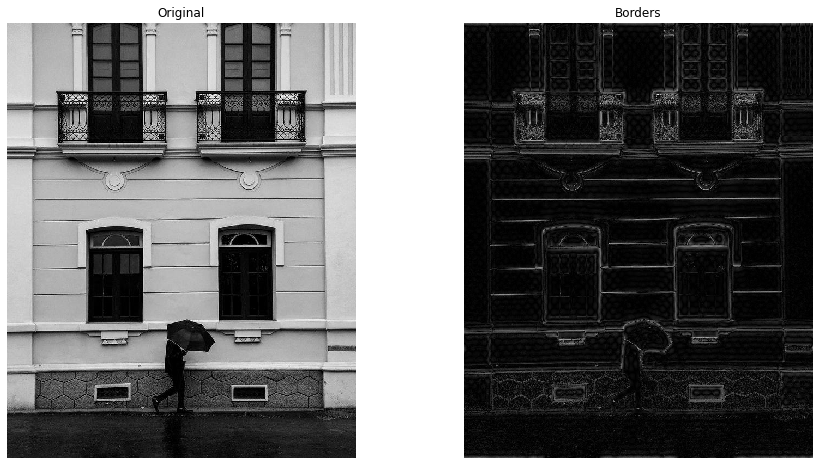

In [10]:
def high_pass(im,r):
    f = fourier(im)
    mask = get_disk_mask(r,f.shape)
    f2 = f*(1-mask)
    return ifourier(f2)
im = imread('walking.jpg')

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=255, interpolation='none')
plt.title('Original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(high_pass(im,40), interpolation='none', cmap=plt.cm.gray)
plt.title('After high-pass filter')
plt.axis('off')
plt.show()

border = np.abs(high_pass(im,40))

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=255, interpolation='none')
plt.title('Original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(border, interpolation='none', cmap=plt.cm.gray)
plt.title('Borders')
plt.axis('off')
plt.show()

**Need more help? You can check the following videos:**

* [Understanding the 2D Fourier transform](https://www.youtube.com/watch?v=bsNQpeBZ7IY&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=18)
* [Filters in Fourier space](https://www.youtube.com/watch?v=8g-sE7wkKpU&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=19)

## 4. Morphological operations

* For morphology functions, [see the skimage documentation](http://scikit-image.org/docs/dev/api/skimage.morphology.html?highlight=morphology#module-skimage.morphology)

Starting from the example below:

1. Using the "opening" operation with a disk structuring element of increasing size, determine how many circles of any given radius there are in the *circles.png* image.
1. Build a morphological filter that eliminates one size of circles.

Text(0.5, 1.0, 'dilation')

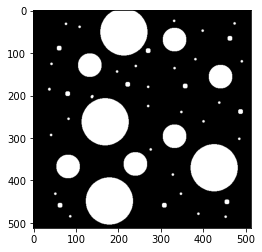

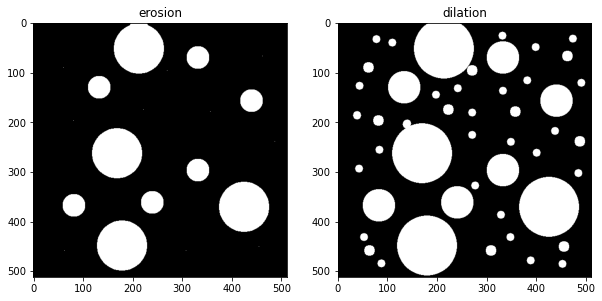

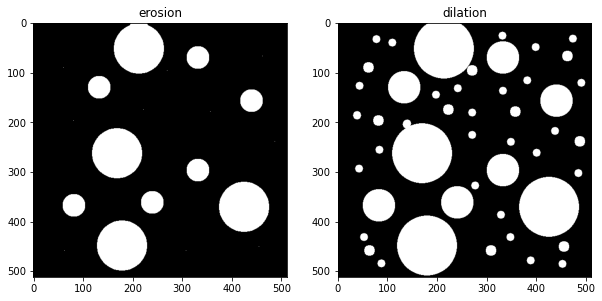

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.io import imread
from skimage.morphology import disk, erosion, dilation

im = imread('circles1.png')==0 #to be sure objects are = 1
plt.imshow(im,cmap=plt.cm.gray);

# use the local maximum and local minimum for dilation and erosion
eroded_image = erosion(im,disk(5))
dilated_image = dilation(im,disk(5))

plt.figure(figsize=[10,8])
plt.subplot(1,2,1)
plt.imshow(eroded_image)
plt.title('erosion')
plt.subplot(1,2,2)
plt.imshow(dilated_image)
plt.title('dilation')

# note that "erosion" and "dilation" are the same as the "local minimum" and "local maximum" :
from skimage.filters.rank import minimum,maximum
eroded_image = minimum(im.astype('uint8'), disk(5))
dilated_image = maximum(im.astype('uint8'), disk(5))

plt.figure(figsize=[10,8])
plt.subplot(1,2,1)
plt.imshow(eroded_image)
plt.title('erosion')
plt.subplot(1,2,2)
plt.imshow(dilated_image)
plt.title('dilation')

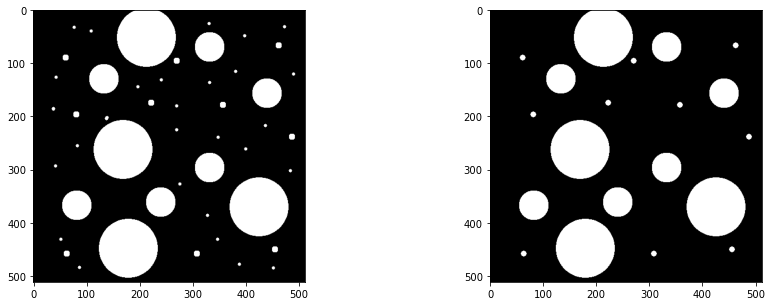

In [12]:
from skimage.morphology import erosion, dilation

def opening(im,sel):
    # Opening = dilation(erosion(image))
    return dilation(erosion(im,sel),sel)>0

# Check if openings work
im_opened = opening(im,disk(4))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(im_opened)
plt.show()

**Need more help? You can check the following videos:**

* [Morphological operations](https://www.youtube.com/watch?v=b64M2dZaWPA&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=20)

## 5. Edge detection

Using the [convolve2d](http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.signal.convolve2d.html) function, develop the Sobel filter. 
The Sobel operator is given by
$$\mathbf{G} = \sqrt{ {\mathbf{G}_x}^2 + {\mathbf{G}_y}^2 }$$
where $G_x$ and $G_y$ are images respectively obtained by a convolution with the given kernels
$$\mathbf{g}_y = \begin{bmatrix} 
    -1 & -2 & -1  \\
    0 & 0 & 0 \\
    +1 & +2 & +1 
    \end{bmatrix}
    \quad
    \mbox{and}
    \quad   
    \mathbf{g}_x = \begin{bmatrix} 
    -1 & 0 & +1 \\
    -2 & 0 & +2 \\
    -1 & 0 & +1 
    \end{bmatrix}
    $$

**Apply the Sobel filter** to find the edges in the "road" image.

Compare with the results of the **Canny edge filter** with different "sigma" values (see [the skimage documentation](http://scikit-image.org/docs/dev/auto_examples/edges/plot_canny.html))

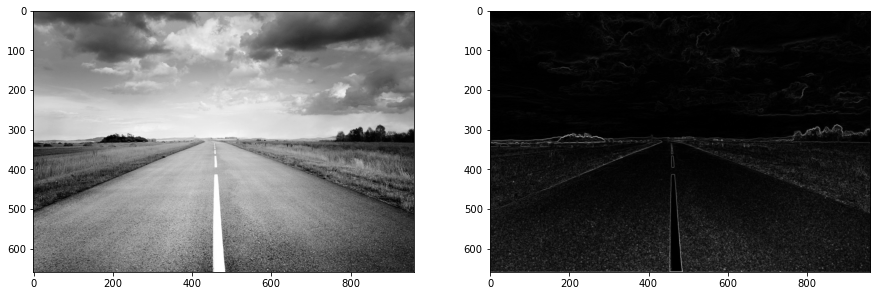

In [13]:
from skimage.data import camera
from skimage.io import imread

## -- Your code here -- ##
from scipy.signal import convolve2d

def sobel(im):
    gy = np.array([[-1.,-2.,-1.],[0.,0.,0.],[1.,2.,1.]])
    gx = gy.T # transpose operator
    Gy = convolve2d(im,gy,'same')
    Gx = convolve2d(im,gx,'same')
    return np.sqrt(Gy**2+Gx**2) # All of those operations will be done element-wise !


im = imread('road.jpg', as_gray=True)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(im, cmap=plt.cm.gray)
plt.subplot(1,2,2)
plt.imshow(sobel(im), cmap=plt.cm.gray)
plt.show()

C:\Users\maxim\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


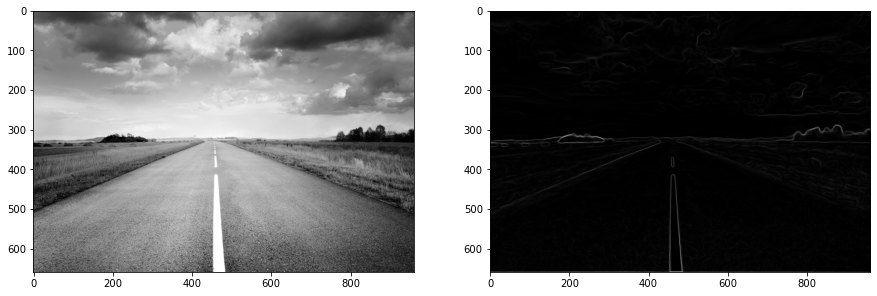

In [14]:
from skimage.filters.rank import median
from skimage.morphology import disk

im = imread('road.jpg', as_gray=True)
im_m = median(im, disk(5))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(im, cmap=plt.cm.gray)
plt.subplot(1,2,2)
plt.imshow(sobel(im_m), cmap=plt.cm.gray)
plt.show()

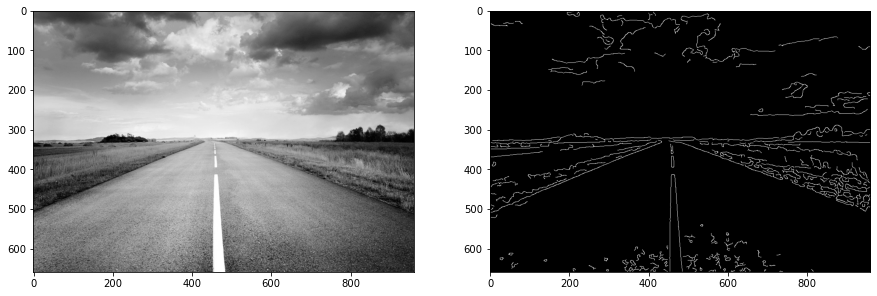

In [15]:
from skimage.feature import canny

im = imread('road.jpg', as_gray=True)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(im, cmap=plt.cm.gray)
plt.subplot(1,2,2)
plt.imshow(canny(im, sigma=2), cmap=plt.cm.gray)
plt.show()

Use the **[Hough transform](http://scikit-image.org/docs/dev/auto_examples/edges/plot_line_hough_transform.html)** to find the main straight lines in the road image, using the results from the Canny edge detector.

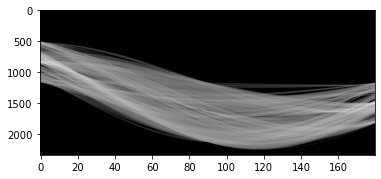

In [16]:
## -- Your code here -- ##
from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line

edges = canny(im, sigma=2)

h, theta, d = hough_line(edges)

plt.figure()
plt.imshow(np.log(h+1), aspect=1/30)
plt.show()

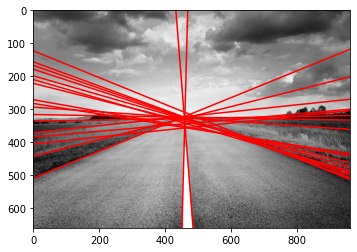

In [17]:
plt.figure()
plt.imshow(im, cmap=plt.cm.gray)
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - im.shape[1] * np.cos(angle)) / np.sin(angle)
    plt.plot((0, im.shape[1]), (y0, y1), '-r')
plt.xlim([0, im.shape[1]])
plt.ylim([im.shape[0],0])
plt.show()

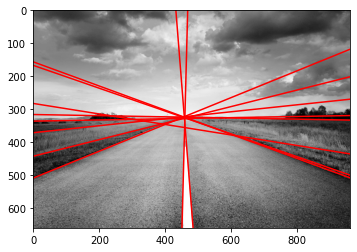

In [18]:
plt.figure()
plt.imshow(im, cmap=plt.cm.gray)
for _, angle, dist in zip(*hough_line_peaks(h, theta, d, num_peaks=10)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - im.shape[1] * np.cos(angle)) / np.sin(angle)
    plt.plot((0, im.shape[1]), (y0, y1), '-r')
plt.xlim([0, im.shape[1]])
plt.ylim([im.shape[0],0])
plt.show()

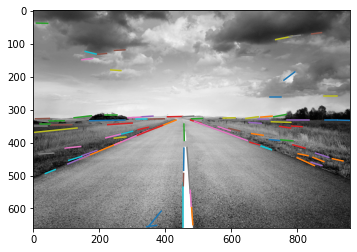

In [19]:
lines = probabilistic_hough_line(edges, threshold=10, line_length=30, line_gap=5)

plt.figure()
plt.imshow(im, cmap=plt.cm.gray)
for line in lines:
    p0, p1 = line
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]))
plt.show()

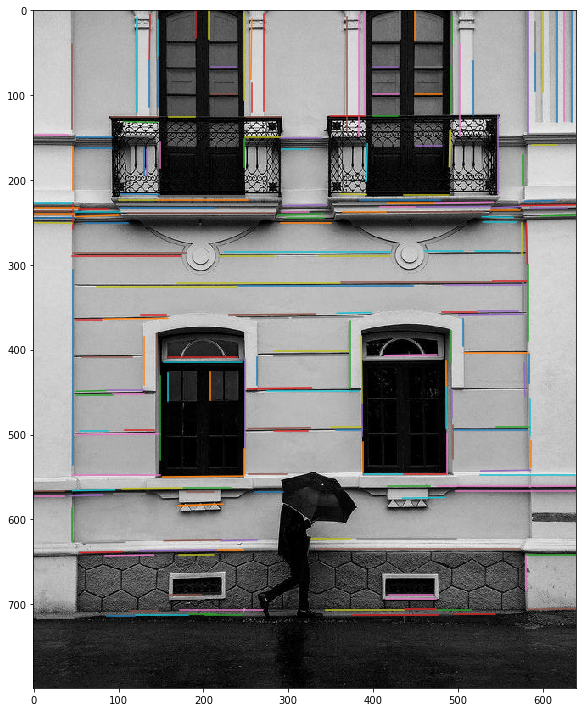

In [20]:
im = imread('walking.jpg')
edges = canny(im, sigma=2)
lines = probabilistic_hough_line(edges, threshold=100, line_length=30, line_gap=5)

plt.figure(figsize=(15,10))
imshow(im)
for line in lines:
    p0, p1 = line
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]))
plt.show()

**Need more help? You can check the following videos:**

* [Edge detection with the Sobel filter](https://www.youtube.com/watch?v=QCjh8yyW-Wo&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=21)
* [Edge detection with the Canny transform](https://www.youtube.com/watch?v=yS5NnpWmuuI&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=22)
* [Line detection with the Hough Transform](https://www.youtube.com/watch?v=GD2xipfKQyY&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=23)

# Coding project - Picture enhancement

Write code that automatically enhances a photograph.

<img src="etretat.jpg" width="250px" />
<img src="ex_enhance.jpg" width="250px" />

"Enhance" may mean a lot of different things, and we encourage you to be creative in which enhancements you want to implement.

Some possibilities include (not an exhaustive list):

* Noise reduction
* Auto-level
* Gamma correction (with gamma provided by the user or automatically determined from the image histogram)
* Increase colour saturation
* ...

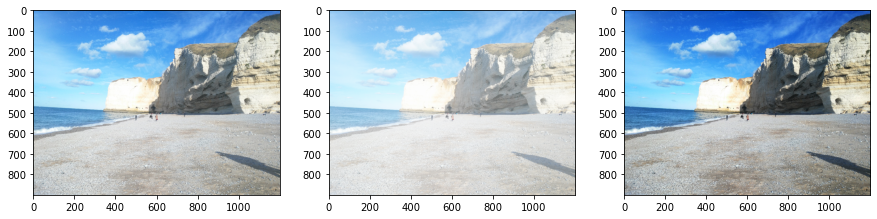

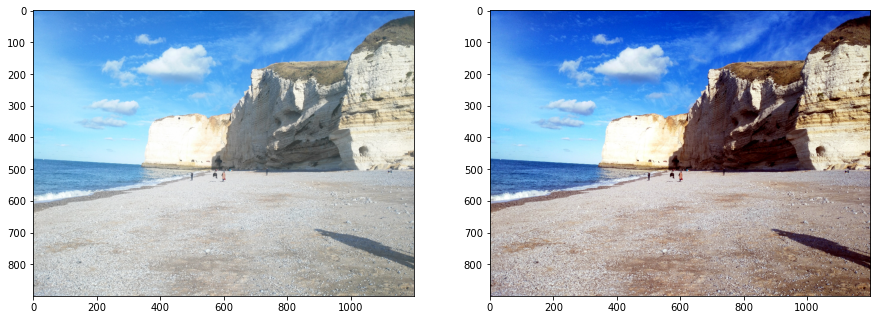

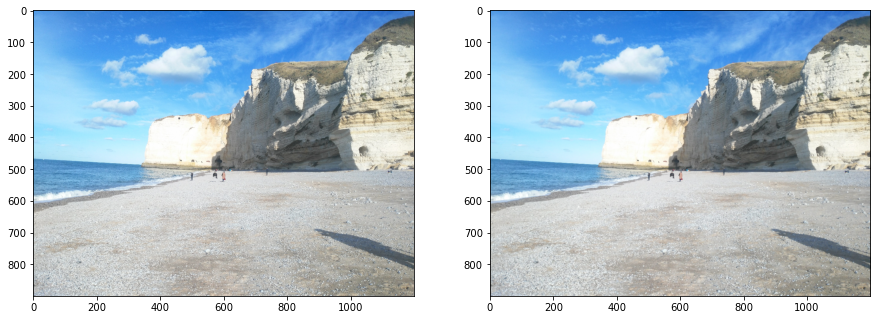

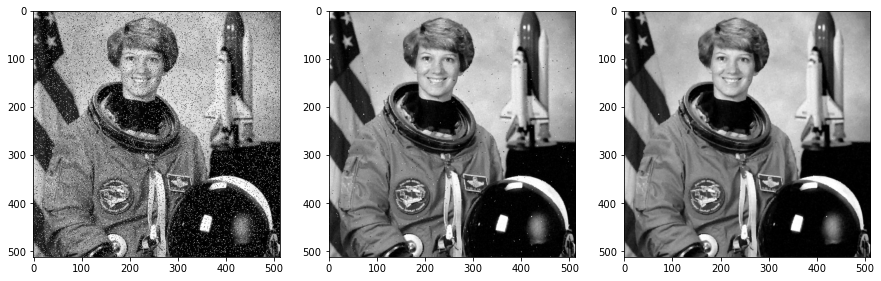

In [32]:
from skimage.io import imread,imshow,imsave
from skimage import data, exposure, img_as_float #see commented code for the pre-existing function from skimage
from skimage.filters.rank import mean, median
from skimage.morphology import disk

im = imread("etretat.jpg")

#GAMMA CORRECTION
#Application of the formula given during the lectures
def gamma_correction(gamma, im):
    A = 255 ** (1-gamma)
    im_out = im.copy()
    im_out = A * im**gamma
    return im_out

#Test with the pre-existing function from skimage
"""im_gamma_low_ex = exposure.adjust_gamma(im, 0.5)
im_gamma_high_ex = exposure.adjust_gamma(im, 1.5)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(im)
plt.subplot(1,3,2)
plt.imshow(im_gamma_low_ex.astype('uint8'))
plt.subplot(1,3,3)
plt.imshow(im_gamma_high_ex.astype('uint8'))
plt.show()"""

#Testing different values for the gamma correction
im_gamma_low = gamma_correction(0.5, im)
im_gamma_high = gamma_correction(1.5, im)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(im)
plt.subplot(1,3,2)
plt.imshow(im_gamma_low.astype('uint8'))
plt.subplot(1,3,3)
plt.imshow(im_gamma_high.astype('uint8'))
plt.show()


#AUTO-LEVEL
#This function builds a look-up table as in exercise 1.4. of this lab:
#Create a LUT:
#To "stretch" the histogram so that, given a minimum value 𝑇𝑚𝑖𝑛 and a maximum value 𝑇𝑚𝑎𝑥, we have :
#    If  𝐼(𝑥,𝑦)<𝑇𝑚𝑖𝑛 , the new value is set to 0
#    If  𝐼(𝑥,𝑦)>𝑇𝑚𝑎𝑥 , the new value is set to 255
#    Values between  𝑇𝑚𝑖𝑛  and  𝑇𝑚𝑎𝑥  are stretched to cover the entire histogram.
#Simply put, applying this look-up table to an image will brighten the already brighter parts, and darken the already darker parts of an image
def build_color_lut(t_min, t_max):
    lut = np.arange(256)
    for i in range(256):
        if i < t_min:
            lut[i] = 0
        elif i > t_max:
            lut[i] = 255
        else:
            lut[i] = (255/(t_max-t_min)) * (lut[i]-t_min)
    return lut

#This function computes the lower and upper threshold that will be used to build the LUT
#The threshold will be computed as percentiles from the cumulative histogram
#The lower threshold will be set at the percentile 2 while the upper threshold will be set at the percentile 98
#This means that 2% of the brightest pixels as well as 2% of the darkest pixels will be lost
#However, the contrast between the remaining pixels will be much more remarkable
def find_thresholds(im):
    #Initialize thresholds:
    Tmin = 0
    Tmax = 255

    #Compute normalized cumulative histogram
    hist, _ = np.histogram(im, bins=np.arange(257), density=True)
    c_hist = np.zeros((256,))
    for i in range(256):
        c_hist[i] = hist[:i+1].sum() #hist[:i+1] will contain the interval [0, i] 

    #Set thresholds based on percentiles:
    #Find lower threshold:
    for i in range(1, 256):
        if c_hist[i] > 0.02:
            Tmin = i-1 # we want the index _before_ we crossed the threshold
            break
    #Find higher threshold
    for i in range(1, 256):
        if c_hist[255-i] < 0.98:
            Tmax = 255-i+1
            break
    return (Tmin,Tmax)

#Extract rgb pixels
im_r = im[:,:,0]
im_g = im[:,:,1]
im_b = im[:,:,2]

#Find thresholds for each color
Tmin_r, Tmax_r = find_thresholds(im_r)
Tmin_g, Tmax_g = find_thresholds(im_g)
Tmin_b, Tmax_b = find_thresholds(im_b)

#Build the look-up table for each color
r_lut = build_color_lut(Tmin_r, Tmax_r)
g_lut = build_color_lut(Tmin_g, Tmax_g)
b_lut = build_color_lut(Tmin_b, Tmax_b)

#Apply the look-up table for auto-level
new_im = im.copy()
new_im[:,:,0] = r_lut[im[:,:,0]]
new_im[:,:,1] = g_lut[im[:,:,1]]
new_im[:,:,2] = b_lut[im[:,:,2]]

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(new_im)
plt.show()


#NOISE REDUCTION
def noise_reduction(im):
    return median(im, disk(1))

im_ast = imread("astronaut_noisy.jpg")

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(im_ast)
plt.subplot(1,3,2)
plt.imshow(noise_reduction(im_ast))
plt.subplot(1,3,3)
plt.imshow(noise_reduction(noise_reduction(im_ast)))
plt.show()